In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from textblob import TextBlob


## Load data

In [10]:
df_train = pd.read_csv('data/original/test.csv')
df_test = pd.read_csv('data/original/test.csv')

# Overview

In [11]:
df_train.head(100)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
95,323,annihilated,NaN,'If your nature appropriates it love will burn...
96,324,annihilated,NaN,@NinaHoag - 'if you shred my Psych work our fr...
97,325,annihilated,upstate NY,@thehill this is 1 example of y the Conservati...
98,326,annihilated,NaN,Aug 3 1915ÛÓKAISERJAEGERS WIPED OUT.; Francis...


In [12]:
df_test.head(100)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
95,323,annihilated,NaN,'If your nature appropriates it love will burn...
96,324,annihilated,NaN,@NinaHoag - 'if you shred my Psych work our fr...
97,325,annihilated,upstate NY,@thehill this is 1 example of y the Conservati...
98,326,annihilated,NaN,Aug 3 1915ÛÓKAISERJAEGERS WIPED OUT.; Francis...


In [13]:
df_train.info()
df_train.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


,id,keyword,location,text
count,3263.000000,3237,2158,3263
unique,NaN,221,1602,3243
top,NaN,deluged,New York,11-Year-Old Boy Charged With Manslaughter of T...
freq,NaN,23,38,3
mean,5427.152927,NaN,NaN,NaN
std,3146.427221,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN
25%,2683.000000,NaN,NaN,NaN
50%,5500.000000,NaN,NaN,NaN
75%,8176.000000,NaN,NaN,NaN


In [14]:
duplicates = df_train.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


## Missing data

<Figure size 1000x600 with 0 Axes>

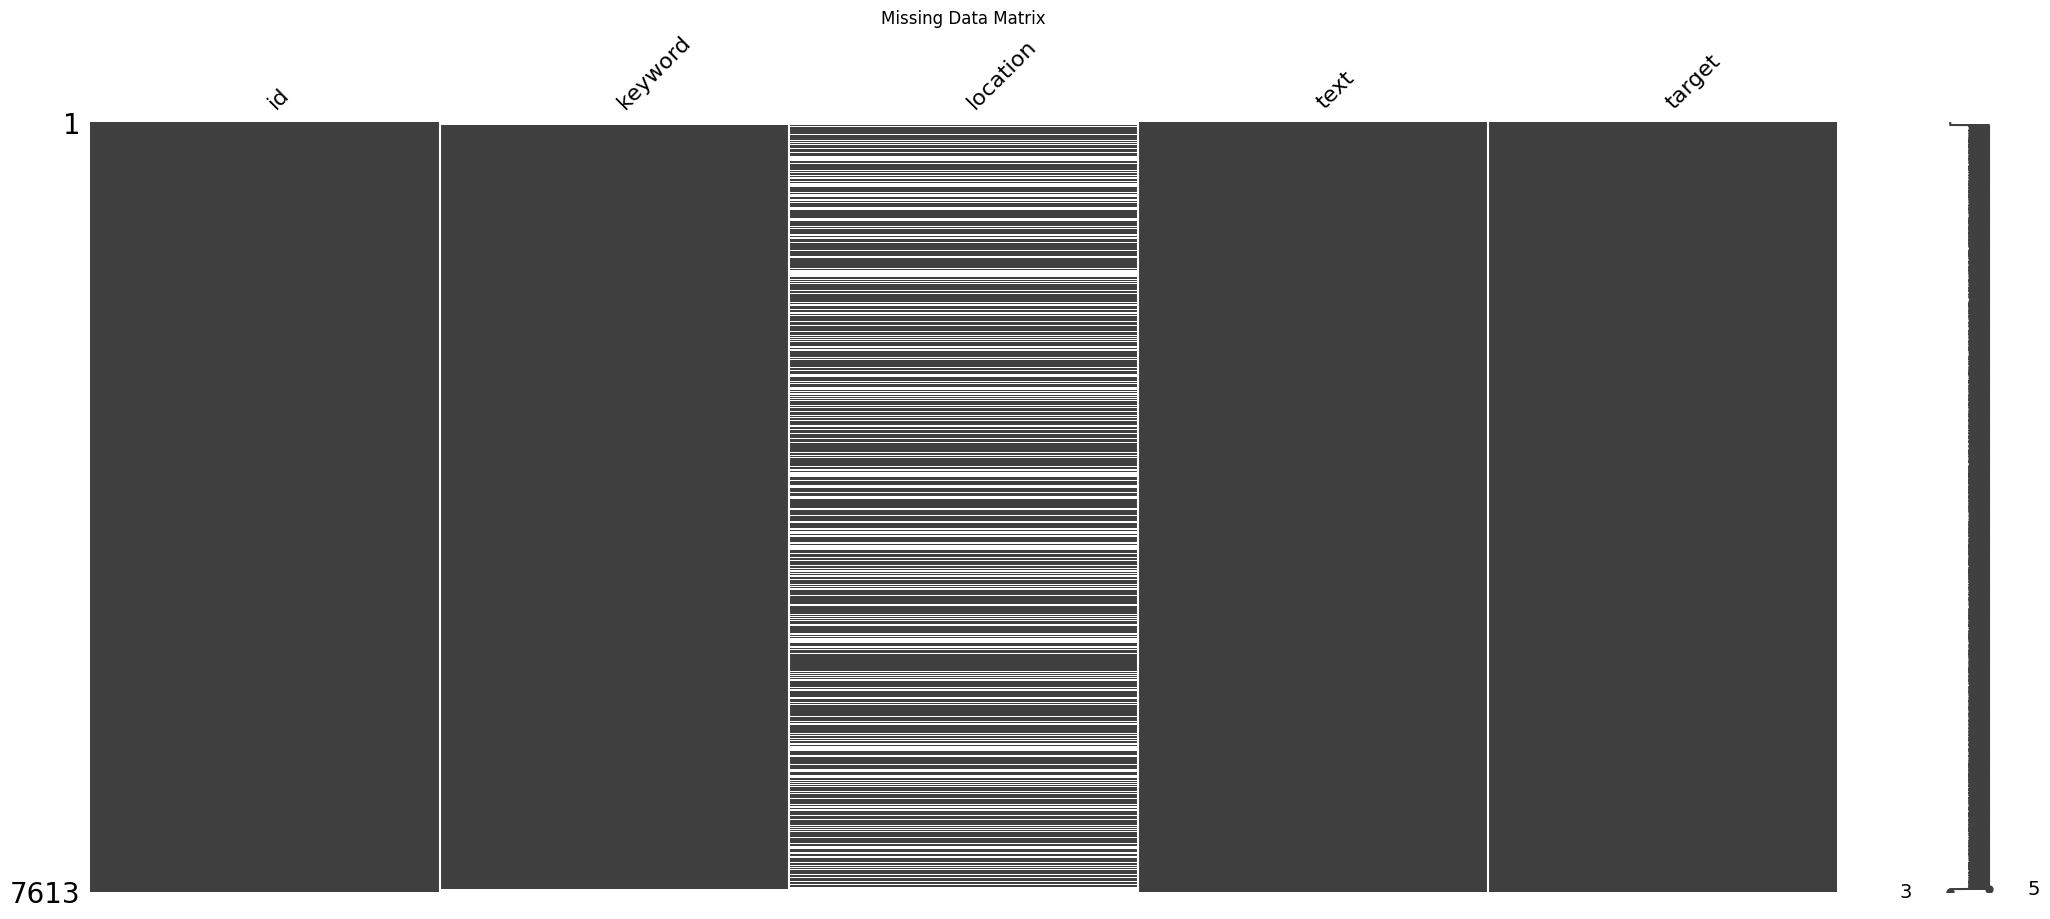

In [6]:
plt.figure(figsize=(10, 6))
msno.matrix(df_train)
plt.title('Missing Data Matrix')
plt.show()

<Axes: >

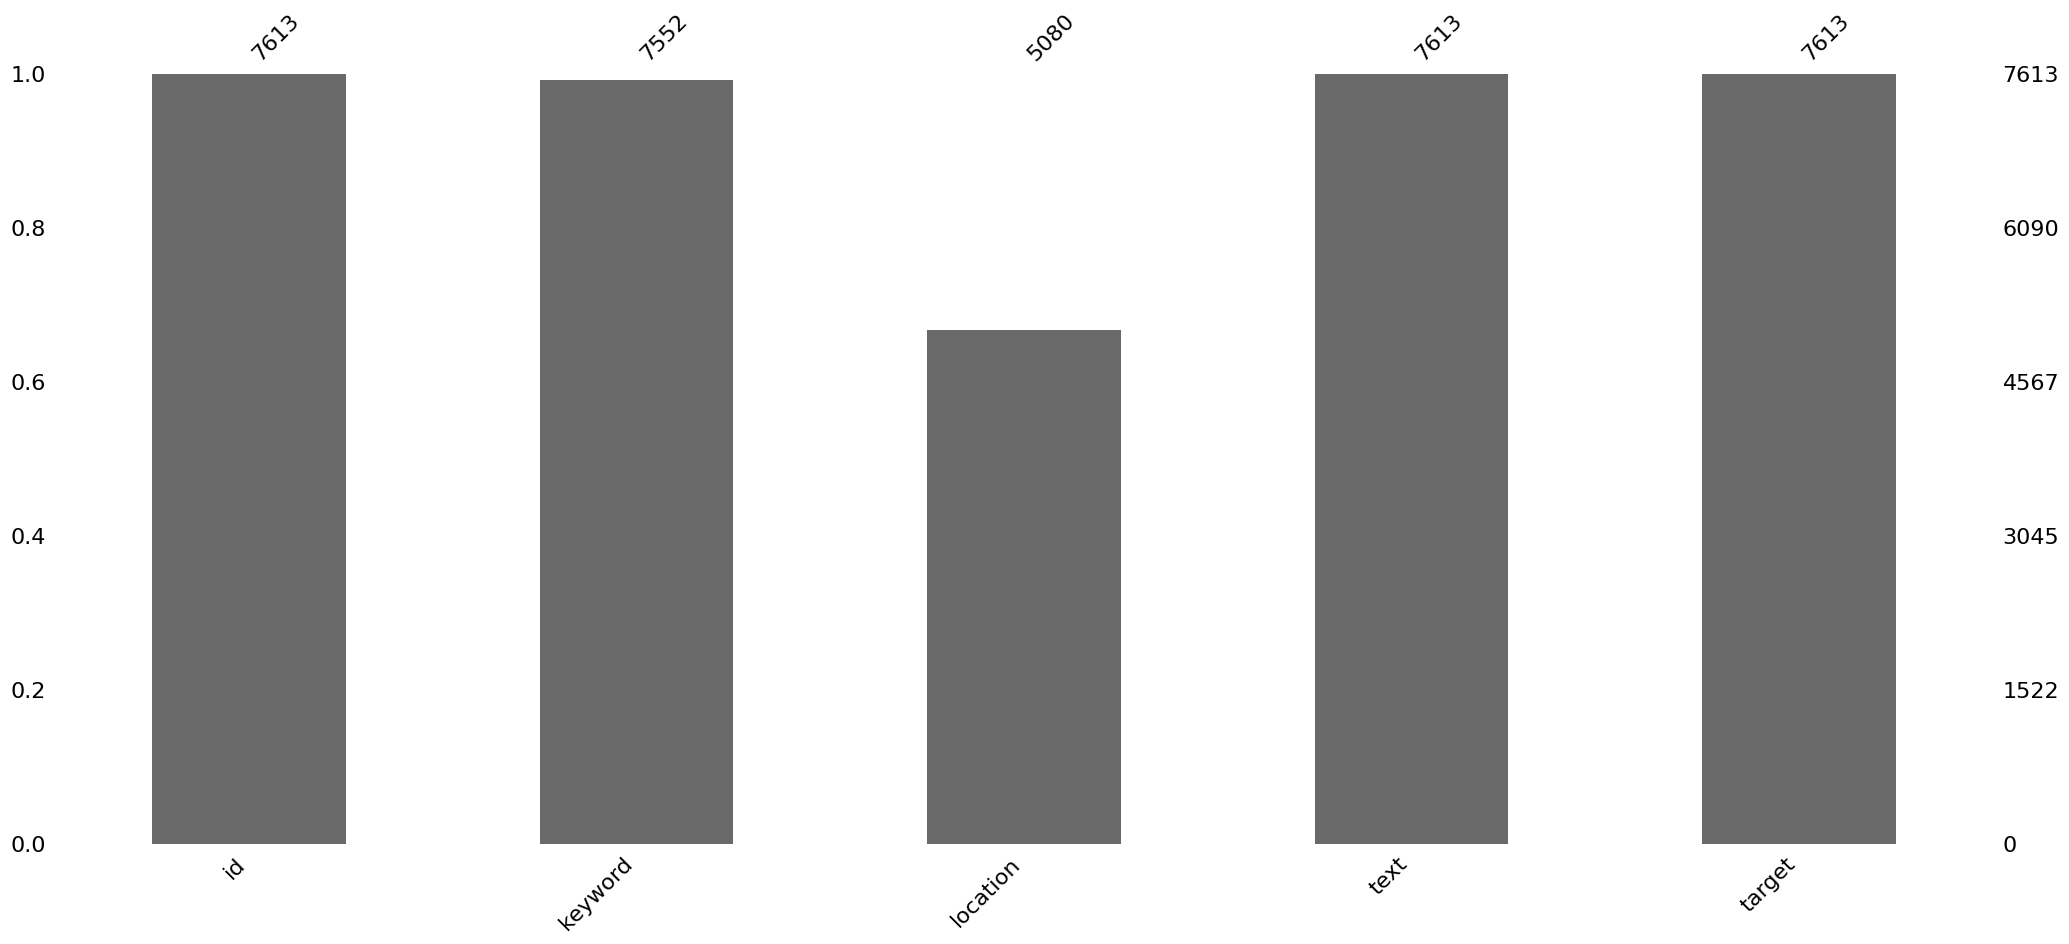

In [7]:
msno.bar(df_train)

<Figure size 1000x600 with 0 Axes>

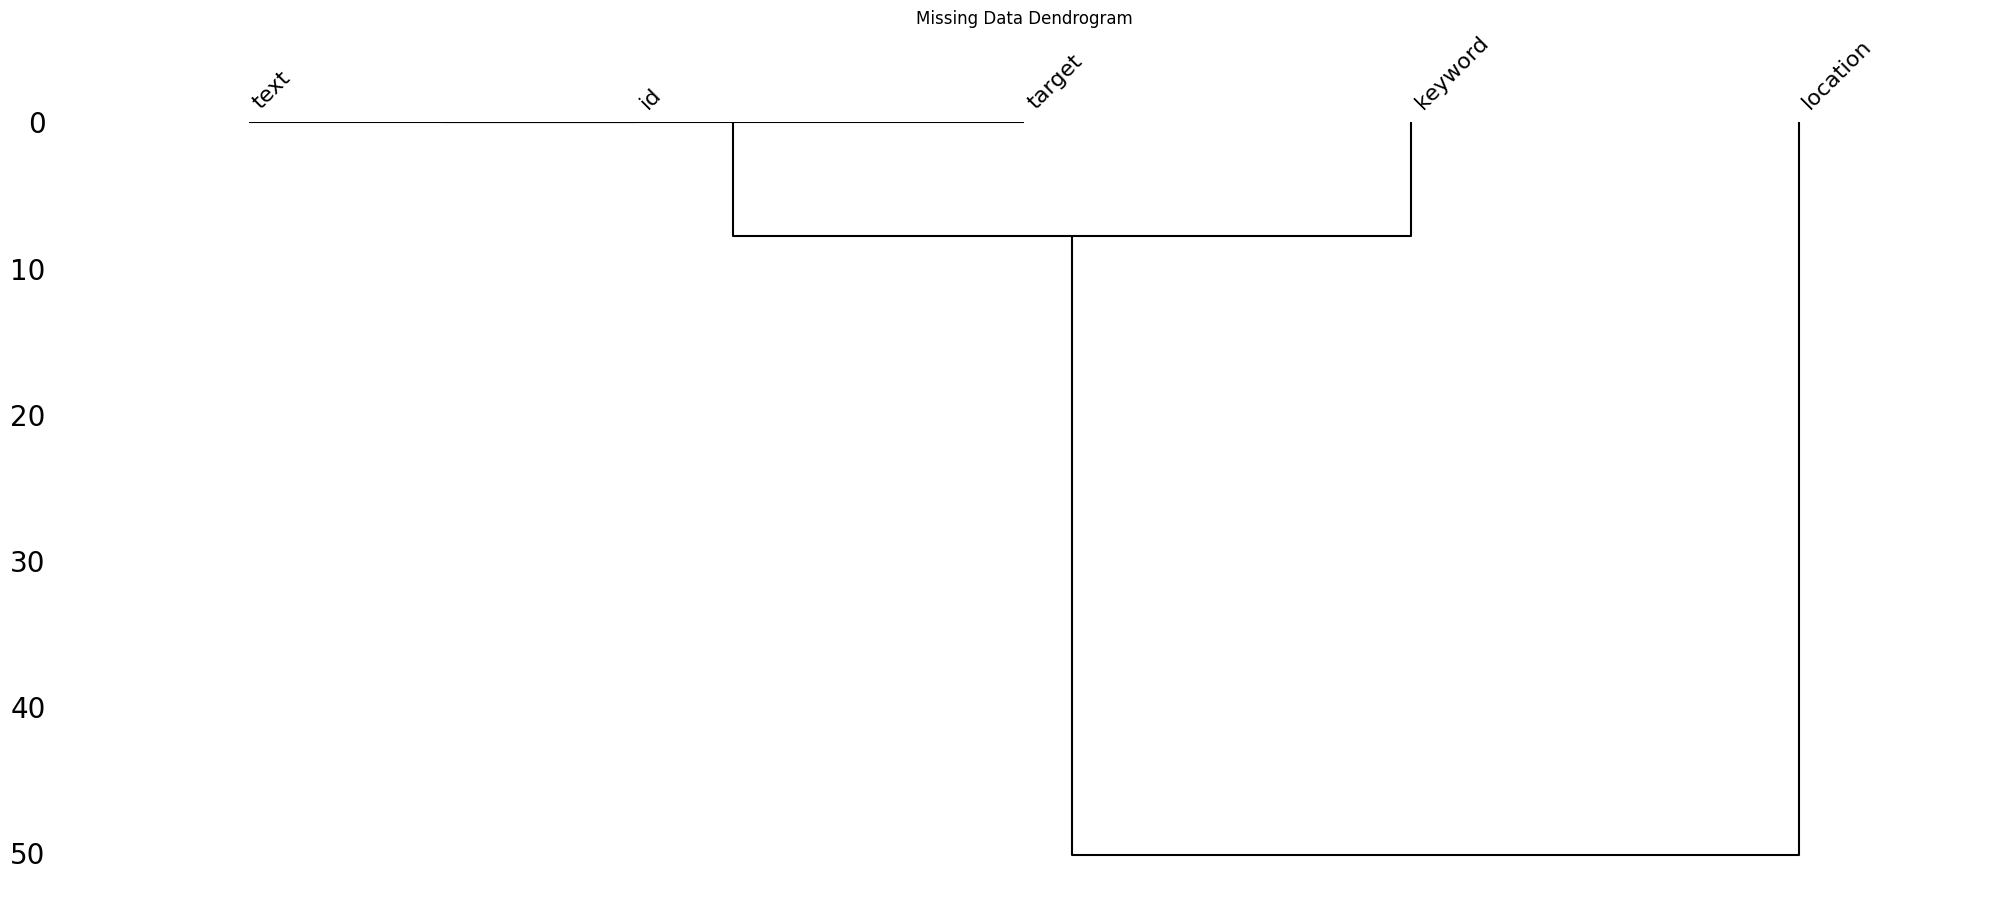

In [8]:
plt.figure(figsize=(10, 6))
msno.dendrogram(df_train)
plt.title('Missing Data Dendrogram')
plt.show()

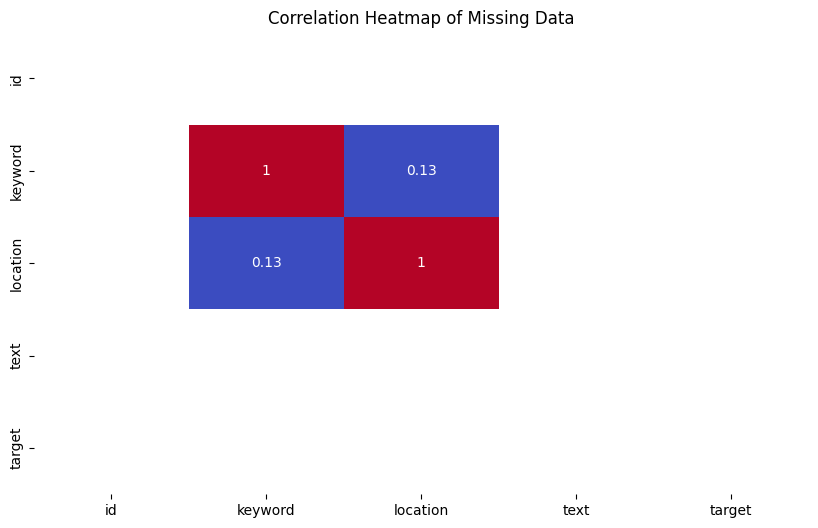

In [9]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_train.isnull().corr(), cmap='coolwarm', annot=True, cbar=False)
plt.title('Correlation Heatmap of Missing Data')
plt.show()

In [10]:
missing_keywords = df_train['keyword'].isnull().sum()
missing_locations = df_train['location'].isnull().sum()
missing_keywords_no_locations = df_train[df_train['keyword'].isnull() & df_train['location'].isnull()].shape[0]

print(f"Missing Keywords: {missing_keywords}")
print(f"Missing Locations: {missing_locations}")
print(f"Missing Keywords with Missing Locations: {missing_keywords_no_locations}")

Missing Keywords: 61
Missing Locations: 2533
Missing Keywords with Missing Locations: 61


## Locations

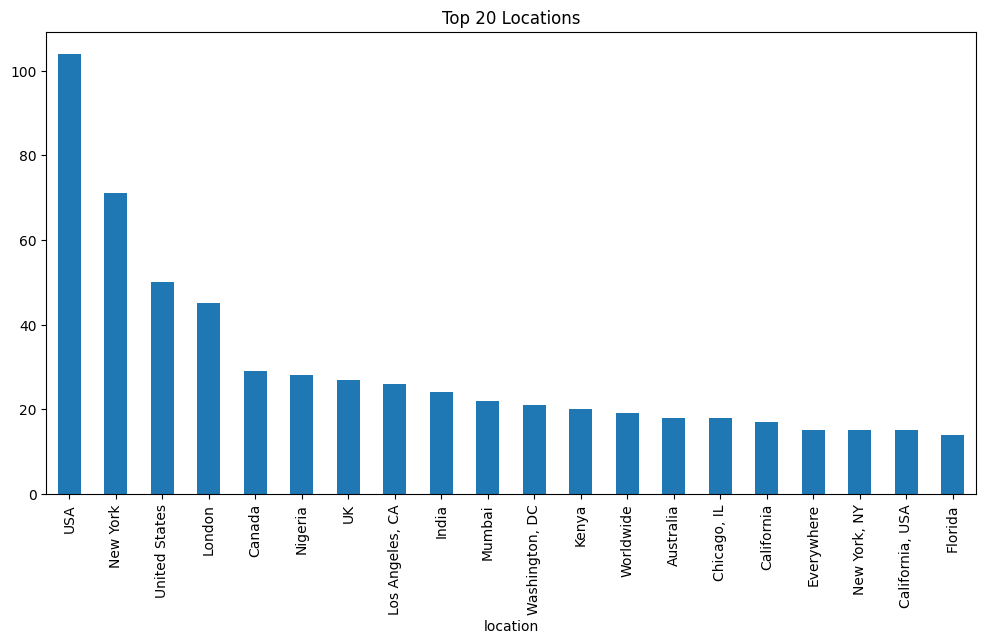

In [11]:
df_train['location'].value_counts().head(20).plot(kind='bar', figsize=(12, 6))
plt.title('Top 20 Locations')
plt.show()

In [12]:
pd.set_option('display.max_rows', None)
df_train['location'].value_counts()

location
USA                                                  104
New York                                              71
United States                                         50
London                                                45
Canada                                                29
Nigeria                                               28
UK                                                    27
Los Angeles, CA                                       26
India                                                 24
Mumbai                                                22
Washington, DC                                        21
Kenya                                                 20
Worldwide                                             19
Australia                                             18
Chicago, IL                                           18
California                                            17
Everywhere                                            15
New York, NY          

In [13]:
from openai import OpenAI
import os
from dotenv import load_dotenv
import json

load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

client = OpenAI(api_key=api_key)

def extract_location_info(df, batch_size=10, model="gpt-4o-mini"):
    extracted_info = []
    
    df = df.dropna(subset=['location'])

    for i in range(0, len(df), batch_size):

        batch_df = df.iloc[i:i + batch_size]
        
        batch_with_ids = [{"id": row["id"], "location": row["location"]} for _, row in batch_df.iterrows()]
        
        prompt = (
            "For each given location, extract the city, country, and continent. "
            "If you can only identify one or two of them, provide only those. If you can provide a city you must also provide a country. "
            "Use standardized names to avoid discrepancies. If you cannot identify city, country, or continent, leave them as empty strings.\n\n"
            "Provide the output in JSON format, where each entry should have this structure:\n"
            '{ "id": <id>, "city": "<city_name>", "country": "<country_name>", "continent": "<continent_name>"}\n\n'
            "Locations:\n" + "\n".join(f'{item["id"]}: {item["location"]}' for item in batch_with_ids)
        )

        response = client.chat.completions.create(
            model=model,
            messages=[
                {
                    "role": "system",
                    "content": "You are an assistant specializing in extracting city and country names. For each location, return the data in the JSON structure specified, without any additional comments.",
                },
                {"role": "user", "content": prompt},
            ],
            temperature=0,
            max_tokens=500,
            n=1,
        )
        locations_data = json.loads(response.choices[0].message.content.strip())

        for loc_data in locations_data:
            try:
                
                if not isinstance(loc_data, dict):
                    raise ValueError("Invalid JSON structure: Not a dictionary")
                required_keys = ["id", "city", "country"]
                for key in required_keys:
                    if key not in loc_data:
                        raise ValueError(f"Invalid JSON structure: Missing '{key}'")
            
            except Exception as e:
                print("Error parsing location data:", loc_data, "Error:", e)
                loc_data = {"id": None, "city": "", "country": ""}
            
            extracted_info.append(loc_data)
    
    return extracted_info



In [14]:
def map_extracted_info_to_df(df, extracted_info):
    extracted_info_df = pd.DataFrame(extracted_info)
    
    df_merged = df.merge(extracted_info_df, on='id', how='left')
    
    return df_merged


In [15]:
# extracted_info_train = extract_location_info(df_train)
# df_train = map_extracted_info_to_df(df_train, extracted_info_train)
# df_train.to_csv('train_extracted_locations.csv', index=False)

# extracted_info_test = extract_location_info(df_test)
# df_test = map_extracted_info_to_df(df_test, extracted_info_test)
# df_test.to_csv('test_extracted_locations.csv', index=False)

In [16]:
df_train = pd.read_csv('train_extracted_locations.csv')
df_test = pd.read_csv('test_extracted_locations.csv')

In [17]:
df_train[110:120]

,id,keyword,location,text,target,city,country,continent
110,160,aftershock,NaN,#GrowingUpSpoiled going clay pigeon shooting a...,0,NaN,NaN,NaN
111,161,aftershock,Somewhere Only We Know ?,So i guess no one actually wants any free Afte...,0,NaN,NaN,NaN
112,162,aftershock,NaN,Aftershock was the most terrifying best roller...,0,NaN,NaN,NaN
113,163,aftershock,Belgium,Aftershock https://t.co/xMWODFMtUI,0,NaN,Belgium,Europe
114,164,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/M4...,0,NaN,Switzerland,Europe
115,165,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0,NaN,United States,North America
116,168,aftershock,NaN,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/e1...,0,NaN,NaN,NaN
117,170,aftershock,dope show,@KJForDays I'm seeing them and Issues at after...,0,NaN,NaN,NaN
118,171,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0,NaN,Switzerland,Europe
119,172,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0,NaN,Switzerland,Europe


In [18]:
df_test[110:120]

,id,keyword,location,text,city,country,continent
110,369,annihilation,California,U.S National Park Services Tonto National Fore...,NaN,United States,North America
111,373,annihilation,"Rhode Island, USA",@BosTeenAuthFest Out of the Silent Planet in p...,NaN,United States,North America
112,374,annihilation,NaN,RT SIGN URGENT Stop the Annihilation of the Sa...,NaN,NaN,NaN
113,376,annihilation,NaN,@jackienatalydlt I do.... I only get the iced ...,NaN,NaN,NaN
114,377,annihilation,U.S.A.,U.S National Park Services Tonto National Fore...,NaN,United States,North America
115,378,annihilation,Arizona,U.S National Park Services Tonto National Fore...,NaN,United States,North America
116,379,annihilation,"Wayne, NJ",@INCIndia under Sonia Gandhi is like Pakistan....,Wayne,United States,North America
117,382,annihilation,Chicago,U.S National Park Services Tonto National Fore...,Chicago,United States,North America
118,385,annihilation,NaN,U.S National Park Services Tonto National Fore...,NaN,NaN,NaN
119,387,annihilation,NaN,Stop the Annihilation of the Salt River Wild H...,NaN,NaN,NaN


## Text Analysis

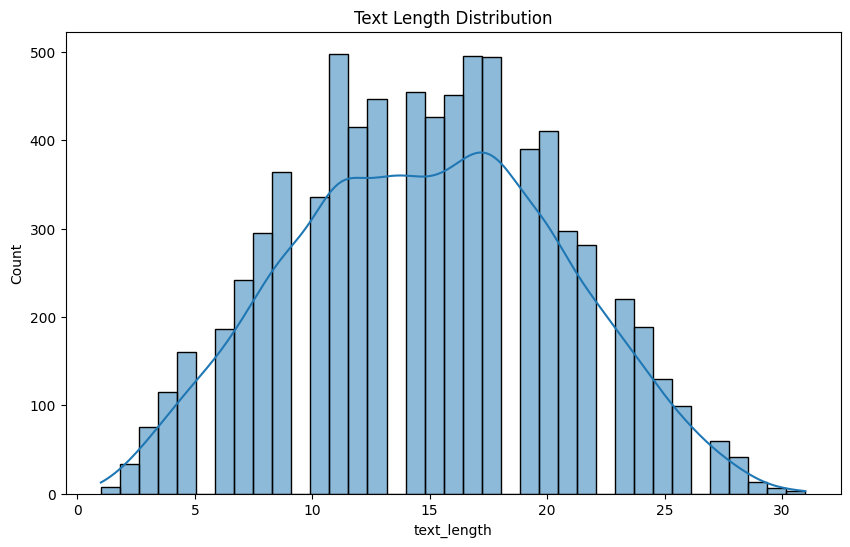

In [19]:
df_train['text_length'] = df_train['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df_train['text_length'], kde=True)
plt.title('Text Length Distribution')
plt.show()


In [20]:
df_train['keyword'].fillna('Unknown', inplace=True)
df_train['location'].fillna('Unknown', inplace=True)

/var/folders/ht/j60glfhj41bg1zk476lf_3n80000gn/T/ipykernel_5848/2102286661.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['keyword'].fillna('Unknown', inplace=True)
/var/folders/ht/j60glfhj41bg1zk476lf_3n80000gn/T/ipykernel_5848/2102286661.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

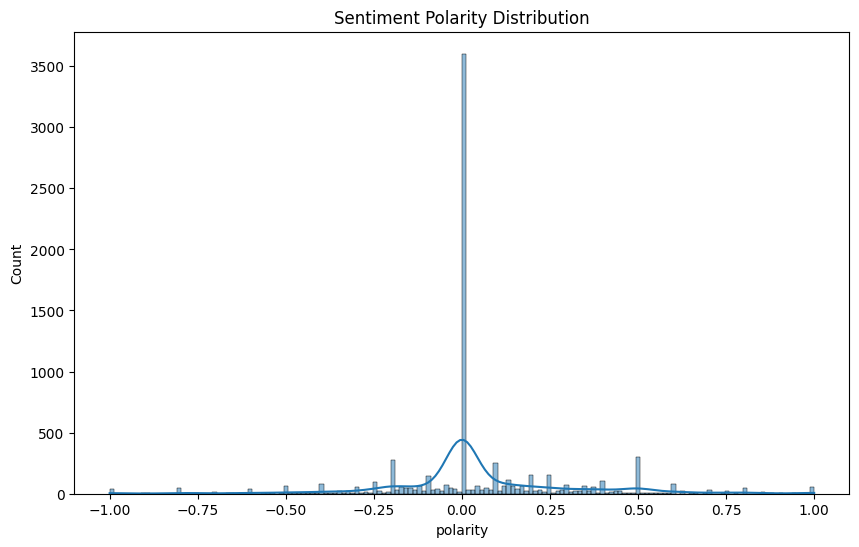

In [21]:
df_train['polarity'] = df_train['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_train['subjectivity'] = df_train['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

plt.figure(figsize=(10, 6))
sns.histplot(df_train['polarity'], kde=True)
plt.title('Sentiment Polarity Distribution')
plt.show()


### Polarity

In [18]:
df_train[df_train['polarity'] == df_train['polarity'].min()]['text'].head(10)

143    Horrible Accident  Man Died In Wings of Airpla...
145    #Horrible #Accident Man Died In Wings Airplane...
152    This is unbelievably insane.\n#man #airport #a...
153    Horrible Accident |  Man Died In Wings of Airp...
154    Horrible Accident Man Died In Wings of Airplan...
162    OMG Horrible Accident Man Died in Wings of Air...
166    My phone looks like it was in a car ship airpl...
426       @58hif my trick is to think about nasty things
454    Horrific attack on wife by muslim in Italy htt...
501    @envw98 @NickCoCoFree @JulieDiCaro @jdabe80 Wh...
Name: text, dtype: object

In [19]:
df_train[df_train['polarity'] == df_train['polarity'].max()]['text'].head(10)

23                                 What a wonderful day!
39                                Ablaze for you Lord :D
47     Building the perfect tracklist to life leave t...
128    'Remembering that you are going to die is the ...
308    Best movie you've ever seen? - Armageddon  htt...
413    #NOWPLAYING Arsonist MC -  So Impressed -  @AR...
429    on town of salem i just melted ice cube bc im ...
611    I liked a @YouTube video http://t.co/XO2ZbPBJB...
830    the best thing at DQ is the cotton candy blizz...
930    That moment when ur about to win a mini uhc an...
Name: text, dtype: object

In [24]:
df_train[(df_train['polarity'] > 0) & (df_train['polarity'] < 0.1)]['text'].head(10)

103    'The man who can drive himself further once th...
112    Aftershock was the most terrifying best roller...
210    THEY SHALL BE ANNIHILATED AND ALL OF THEIR PET...
236    @TomcatArts 'who then were annihilated by the ...
256    @CalFreedomMom @steph93065 not to mention a ma...
260    The annihilation of Jeb Christie &amp; Kasich ...
279    She's kinda hot played on the radio today. Wha...
341    9 Charts Prove Financial Crisis Part 2 Has BEG...
352    Seeing that army of whitewalkers was the very ...
369    WWI WWII JAPANESE ARMY NAVY MILITARY JAPAN LEA...
Name: text, dtype: object

### Subjectivity

In [ ]:
df_train[df_train['subjectivity'] == df_train['subjectivity'].min()]['text'].head(10)

0     Our Deeds are the Reason of this #earthquake M...
3     13,000 people receive #wildfires evacuation or...
4     Just got sent this photo from Ruby #Alaska as ...
8     There's an emergency evacuation happening now ...
12    #raining #flooding #Florida #TampaBay #Tampa 1...
13              #Flood in Bago Myanmar #We arrived Bago
14    Damage to school bus on 80 in multi car crash ...
15                                       What's up man?
19                         What a goooooooaaaaaal!!!!!!
24                                             LOOOOOOL
Name: text, dtype: object

In [22]:
df_train[df_train['subjectivity'] == df_train['subjectivity'].max()]['text'].head(10)

10           Three people died from the heat wave so far
20                                this is ridiculous....
23                                 What a wonderful day!
28                                             Cooool :)
39                                Ablaze for you Lord :D
47     Building the perfect tracklist to life leave t...
67     'I can't have kids cuz I got in a bicycle acci...
126    'The only thing that stands between you and yo...
143    Horrible Accident  Man Died In Wings of Airpla...
145    #Horrible #Accident Man Died In Wings Airplane...
Name: text, dtype: object

In [23]:
df_train[(df_train['subjectivity'] > 0) & (df_train['subjectivity'] < 0.1)]['text'].head(10)

26                                 Was in NYC last week!
35     On plus side LOOK AT THE SKY LAST NIGHT IT WAS...
45     I gained 3 followers in the last week. You? Kn...
56     TRUCK ABLAZE : R21. VOORTREKKER AVE. OUTSIDE O...
100    .@NorwayMFA #Bahrain police had previously die...
194    @Kiwi_Karyn Check out what's in my parking lot...
290    Dad bought a DVD that looks like a science doc...
341    9 Charts Prove Financial Crisis Part 2 Has BEG...
368    Stony Jackson is America's last hope as he lea...
538    .@bigperm28 was drafted by the @Avalanche in 2...
Name: text, dtype: object